# Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib.lines import Line2D
plt.style.use('seaborn-v0_8')

In [2]:
from sklearn.metrics import precision_score, recall_score, make_scorer, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix, accuracy_score, log_loss

In [3]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html

In [4]:
from utils import aif_test, aif_plot, aif_plot2

In [5]:
X_train_f = pd.read_csv("./output/X_train_f.csv")
X_train_s = pd.read_csv("./output/X_train_s.csv")

X_test_f = pd.read_csv("./output/X_test_f.csv")
X_test_s = pd.read_csv("./output/X_test_s.csv")
y_test = pd.read_csv("./output/y_test.csv")

preds_test = pd.read_csv("./output/preds_test.csv")

# 01 Plot risk scores

In [7]:
comb_test = pd.read_csv("./output/comb_test.csv")

<Axes: xlabel='glm1_p', ylabel='Density'>

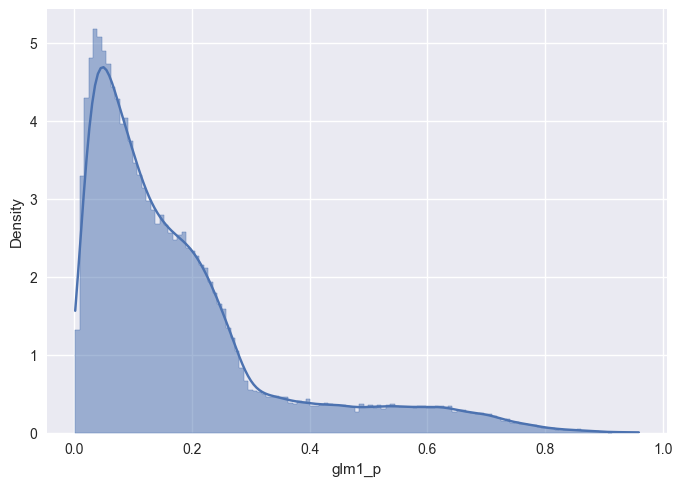

In [8]:
sns.histplot(data = comb_test, x = 'glm1_p', kde = True, stat = 'density', common_norm = False, element = 'step')
#sns.histplot(data = comb_test, x = 'glm2b_p', kde = True, stat = 'density', common_norm = False, element = 'step', color = 'g')

In [10]:
sns.set_theme(font_scale = 1.1)

In [13]:
threshold30 = np.sort(comb_test.glm1_p)[::-1][int(0.30*len(comb_test.glm1_p))]
threshold15 = np.sort(comb_test.glm1_p)[::-1][int(0.15*len(comb_test.glm1_p))]

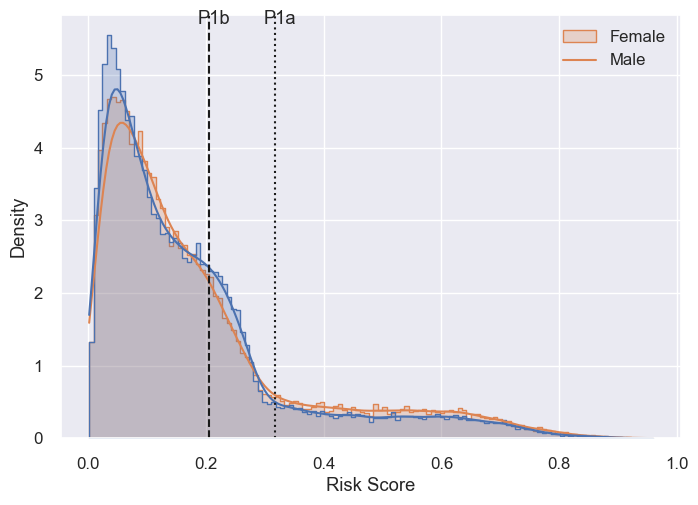

In [14]:
sns_plot = sns.histplot(data = comb_test, x = 'glm1_p', hue = 'frau1', kde = True, stat = 'density', common_norm = False, element = 'step')
sns_plot.set(xlabel = 'Risk Score')
sns_plot.legend(title = '', labels = ['Female', 'Male'])
sns_plot.axvline(threshold30, color='k', linestyle='dashed')
sns_plot.axvline(threshold15, color='k', linestyle='dotted')
sns_plot.text(threshold15 - 0.02, 5.7, 'P1a')
sns_plot.text(threshold30 - 0.02, 5.7, 'P1b')
sns_plot.figure.savefig('glm1_p_sex.png', dpi = 300)

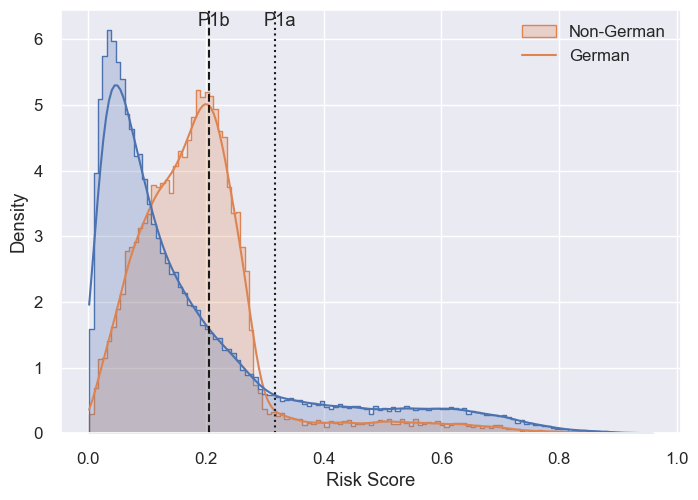

In [15]:
sns_plot = sns.histplot(data = comb_test, x = 'glm1_p', hue = 'nongerman', kde = True, stat = 'density', common_norm = False, element = 'step')
sns_plot.set(xlabel = 'Risk Score')
sns_plot.legend(title = '', labels = ['Non-German', 'German'])
sns_plot.axvline(threshold30, color='k', linestyle='dashed')
sns_plot.axvline(threshold15, color='k', linestyle='dotted')
sns_plot.text(threshold15 - 0.02, 6.2, 'P1a')
sns_plot.text(threshold30 - 0.02, 6.2, 'P1b')
sns_plot.figure.savefig('glm1_p_ger.png', dpi = 300)

# 02 Performance and Fairness vs. Threshold Plots
# https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb

In [16]:
label_test = pd.concat([y_test, X_test_f], axis = 1)

label_test.loc[label_test['maxdeutsch.Missing.'] == 1, 'maxdeutsch1'] = np.nan
preds_test.loc[label_test['maxdeutsch.Missing.'] == 1, 'y_test'] = np.nan

label_test = label_test.dropna()
preds_test = preds_test.dropna()

In [ ]:
# Loop over models (w/o protected attributes) and create plots

# ...

# 03 Fairness vs Accuracy Plots

In [17]:
f1_group = pd.read_csv("./output/f1_group.csv")
f1_group = f1_group.loc[(f1_group['pop'] != 'Overall')]
acc_group = pd.read_csv("./output/acc_group.csv")
acc_group = acc_group.loc[(acc_group['pop'] != 'Overall')]


In [18]:
fairness1 = pd.read_csv("./output/test_fairness1.csv")
fairness1 = fairness1.iloc[1: , :]
cond_fair1 = pd.read_csv("./output/test_cond_fairness1.csv")
cond_fair1 = cond_fair1.iloc[1: , :]

In [19]:
fairness1[['method', 'Type', 'Cutoff']] = fairness1['Model'].str.split(pat='(\d)', n=1, expand=True) # Split up cols

In [20]:
fairness = fairness1 #.append([fairness1b, fairness2, fairness2b]) # Append
fairness = fairness.reset_index(drop = True)

In [21]:
fairness['Cutoff'] = fairness['Cutoff'].str.replace(r'_', '') # Clean up
fairness = fairness.loc[(fairness['Cutoff'] == 'c1') | (fairness['Cutoff'] == 'c2')]
fairness['method'] = fairness['method'].astype('category')
fairness['method'] = fairness['method'].cat.rename_categories({'glm': 'LR', 
                                                               'net': 'PLR', 
                                                               'rf': 'RF', 
                                                               'gbm': 'GBM'})
fairness = fairness.drop(columns = ['Model'])

In [22]:
fairness = fairness.melt(id_vars=['method', 'Type', 'Cutoff'], var_name = 'pop') # Long format
fairness['pop'] = fairness['pop'].astype('category')
fairness['pop'] = fairness['pop'].cat.rename_categories({'Parity Diff. (Female)': 'Female', 
                                                         'Parity Diff. (Non-German)': 'Non-German', 
                                                         'Parity Diff. (Non-German-Male)': 'Non-Ger. M', 
                                                         'Parity Diff. (Non-German-Female)': 'Non-Ger. F'})


In [23]:
fairness = fairness.rename(columns={'value': 'Parity Diff.'})


In [27]:
# Added from me

# Ensure 'Type' is the same dtype in both DataFrames
fairness['Type'] = fairness['Type'].astype(str)
f1_group['Type'] = f1_group['Type'].astype(str)

acc_group['Type'] = acc_group['Type'].astype(str)


In [28]:
fair_f1 = pd.merge(fairness, f1_group, on=['pop', 'method', 'Type', 'Cutoff']) # Merge
fair_acc = pd.merge(fairness, acc_group, on=['pop', 'method', 'Type', 'Cutoff'])

# Plots

<Axes: xlabel='Parity Diff.', ylabel='value'>

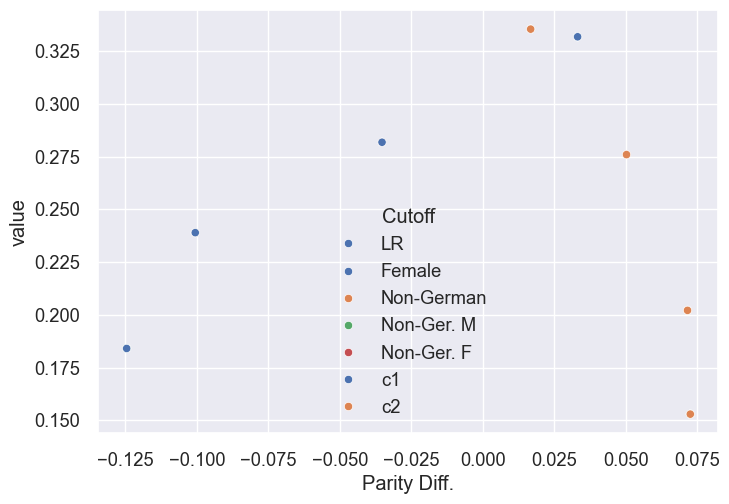

In [29]:
sns.set(font_scale = 1.2)

sns.scatterplot(x = "Parity Diff.", y = "value", hue = 'method', data = fair_f1)
sns.scatterplot(x = "Parity Diff.", y = "value", hue = 'pop', data = fair_f1)
sns.scatterplot(x = "Parity Diff.", y = "value", hue = 'Cutoff', data = fair_f1)


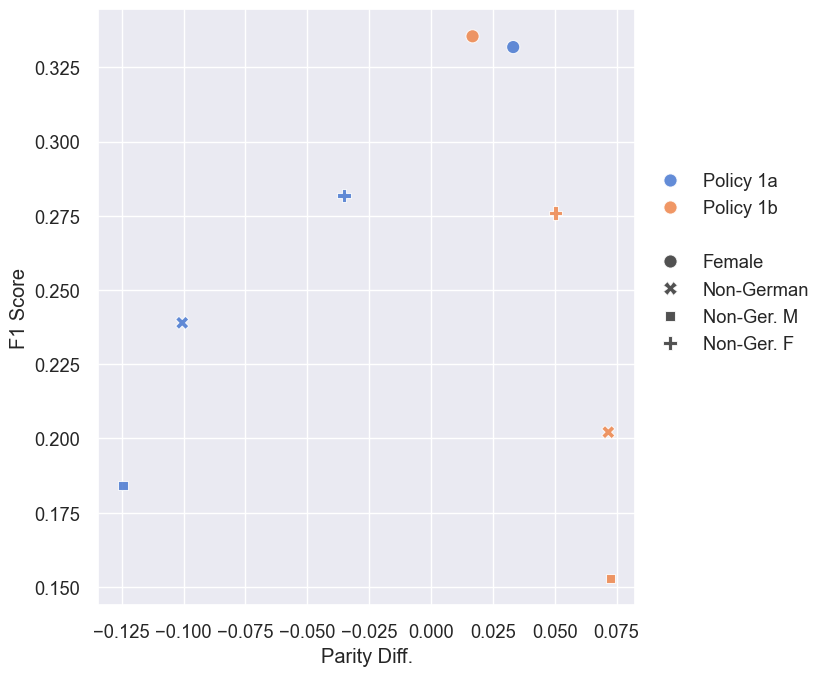

In [30]:
fig, ax = plt.subplots(figsize = (8.5, 7))
ax = sns.scatterplot(data = fair_f1, x = "Parity Diff.", y = "value", hue = 'Cutoff', style = 'pop', palette = "muted", s = 90, alpha = 0.85)
ax.set_xlabel("Parity Diff.")
ax.set_ylabel("F1 Score")
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['', 'Policy 1a', 'Policy 1b', '', 'Female', 'Non-German', 'Non-Ger. M', 'Non-Ger. F'], bbox_to_anchor = (1, 0.8), loc = 2)
plt.tight_layout()
plt.savefig('./output/fair_f1', dpi = 300)

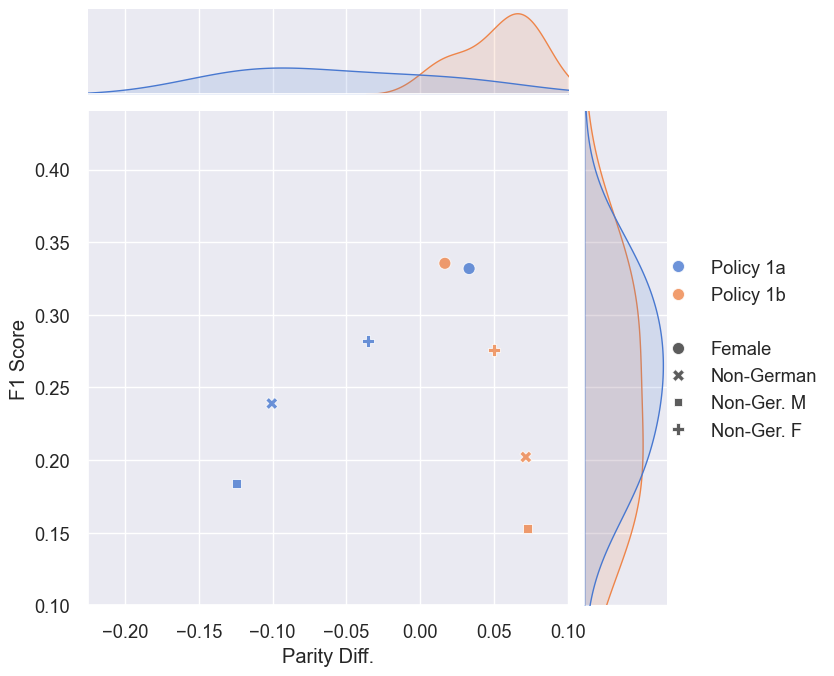

In [31]:
g = sns.JointGrid(data = fair_f1, x = "Parity Diff.", y = "value", hue = 'Cutoff', palette = "muted", xlim = [-0.225, 0.1], ylim = [0.1, 0.44], height = 7, ratio = 5)
g.plot_joint(sns.scatterplot, style = 'pop', data = fair_f1, s = 75, alpha = 0.8)
g.plot_marginals(sns.kdeplot, fill = True, alpha = 0.15, bw_adjust = .9, linewidth = 1)
g.set_axis_labels('Parity Diff.', 'F1 Score')
g.ax_joint.legend_._visible = False
handles, labels = g.ax_joint.get_legend_handles_labels()
g.fig.legend(handles = handles, labels = ['', 'Policy 1a', 'Policy 1b', '', 'Female', 'Non-German', 'Non-Ger. M', 'Non-Ger. F'], bbox_to_anchor = (0.935, 0.675), loc = 2)
g.savefig('./output/fair_f1_joint', dpi = 300)

<Axes: xlabel='Parity Diff.', ylabel='value'>

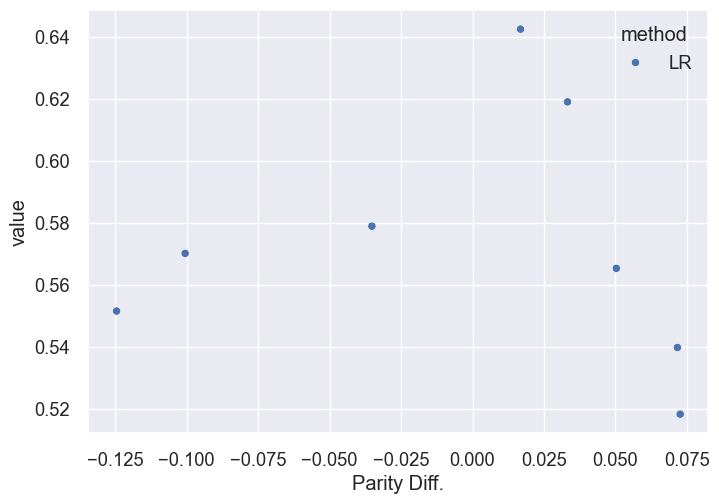

In [32]:
sns.scatterplot(x = "Parity Diff.", y = "value", hue = 'method', data = fair_acc)

<Axes: xlabel='Parity Diff.', ylabel='value'>

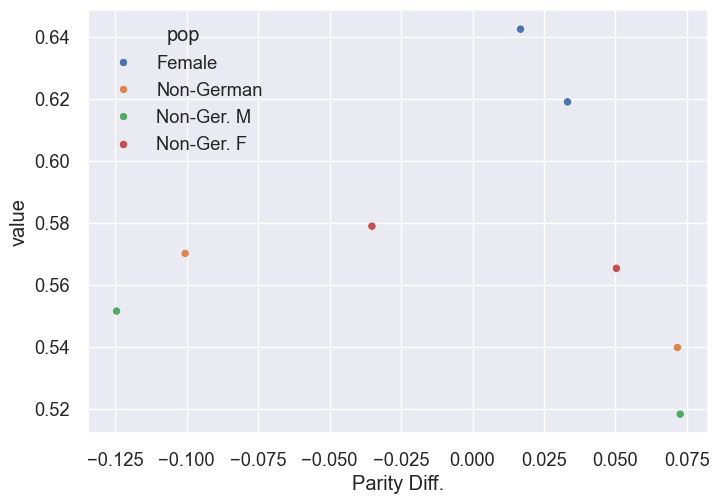

In [33]:
sns.scatterplot(x = "Parity Diff.", y = "value", hue = 'pop', data = fair_acc)

<Axes: xlabel='Parity Diff.', ylabel='value'>

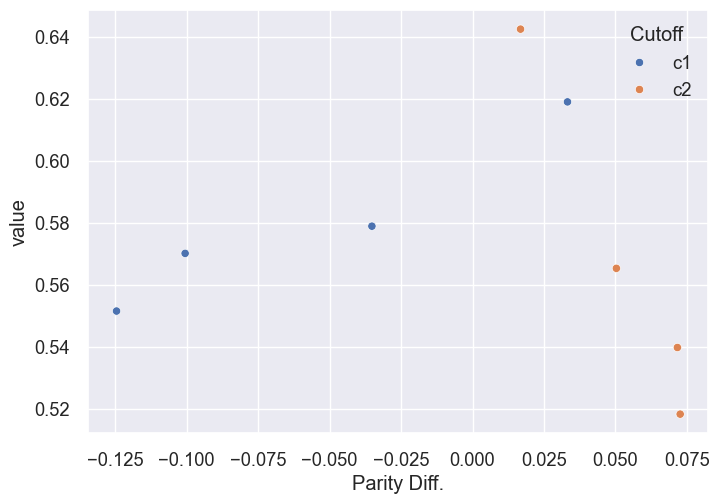

In [34]:
sns.scatterplot(x = "Parity Diff.", y = "value", hue = 'Cutoff', data = fair_acc)

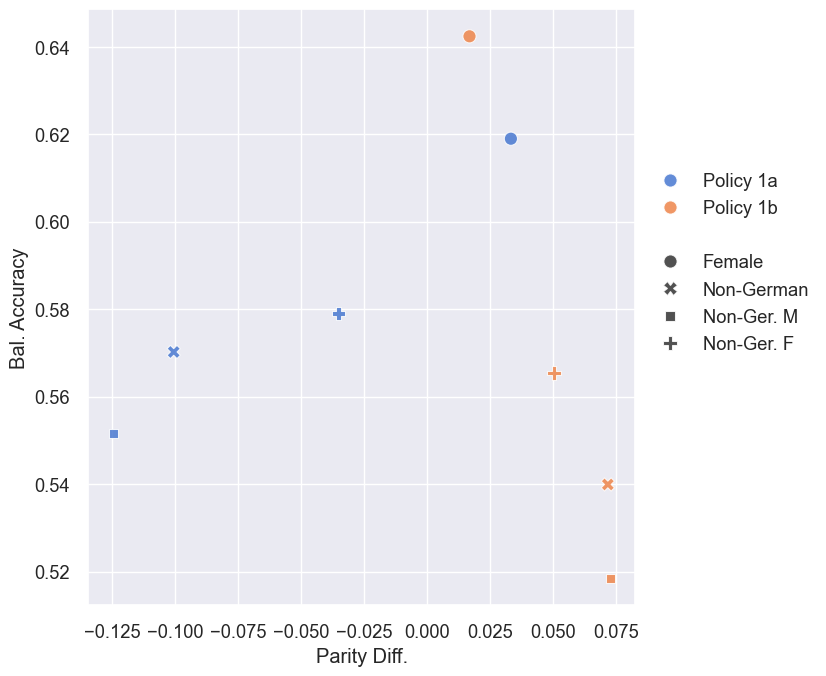

In [35]:
fig, ax = plt.subplots(figsize = (8.5, 7))
ax = sns.scatterplot(data = fair_acc, x = "Parity Diff.", y = "value", hue = 'Cutoff', style = 'pop', palette = "muted", s = 90, alpha = 0.85)
ax.set_xlabel("Parity Diff.")
ax.set_ylabel("Bal. Accuracy")
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['', 'Policy 1a', 'Policy 1b', '', 'Female', 'Non-German', 'Non-Ger. M', 'Non-Ger. F'], bbox_to_anchor = (1, 0.8), loc = 2)
plt.tight_layout()
plt.savefig('./output/fair_acc', dpi = 300)

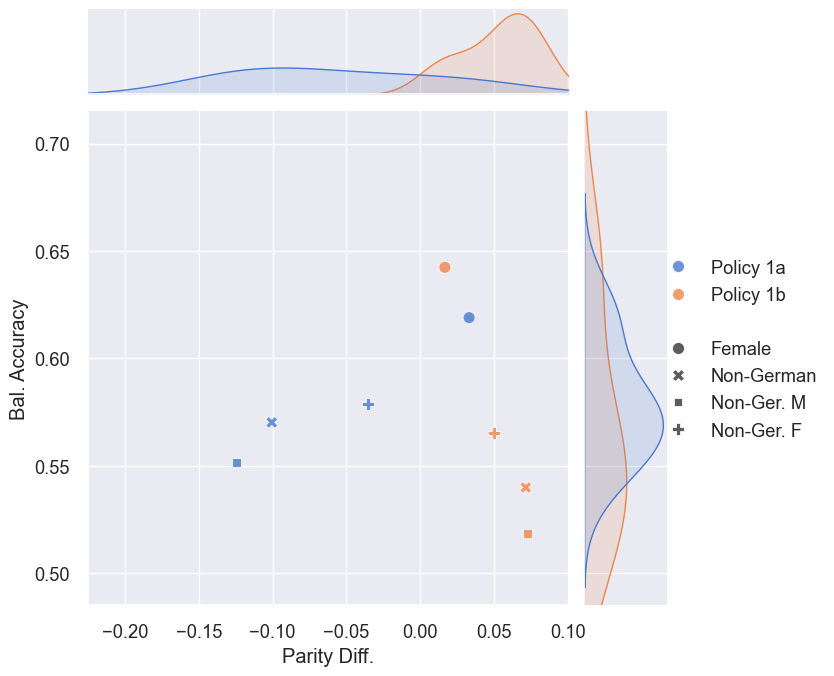

In [36]:
g = sns.JointGrid(data = fair_acc, x = "Parity Diff.", y = "value", hue = 'Cutoff', palette = "muted", xlim = [-0.225, 0.1], ylim = [0.485, 0.715], height = 7, ratio = 5)
g.plot_joint(sns.scatterplot, style = 'pop', data = fair_f1, s = 75, alpha = 0.8)
g.plot_marginals(sns.kdeplot, fill = True, alpha = 0.15, bw_adjust = .9, linewidth = 1)
g.set_axis_labels('Parity Diff.', 'Bal. Accuracy')
g.ax_joint.legend_._visible = False
handles, labels = g.ax_joint.get_legend_handles_labels()
g.fig.legend(handles = handles, labels = ['', 'Policy 1a', 'Policy 1b', '', 'Female', 'Non-German', 'Non-Ger. M', 'Non-Ger. F'], bbox_to_anchor = (0.935, 0.675), loc = 2)
g.savefig('./output/fair_acc_joint', dpi = 300)